## EEGNet model implementation for 4 classes

In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


11.8
True


In [2]:
import os
import mne
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

# Scikit-Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
     

In [3]:
fs= 200                 #sampling frequency (AFTER CHANGES?)
channel= 32              #electrodes
num_input= 1             #number of channel picture (for EEG signal is always : 1)
num_class= 4             #classes 
signal_length = 267      #number of sample in each AFTER THE DOWNSAMPLING AND SLICING => X = X[:,:,200*2:200*6] and X = X[:,:,0:-1:3]

F1= 8                    #number of temporal filters
D= 3                     #depth multiplier (number of spatial filters)
F2= D*F1                 #number of pointwise filters

In [4]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
kernel_size_1= (1,round(fs/2)) 
kernel_size_2= (channel, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
class EEGNet(nn.Module): 
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d = nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1 = nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D = nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
        self.Batch_normalization_2 = nn.BatchNorm2d(D*F1)
        self.Elu = nn.ELU()
        self.Average_pooling2D_1 = nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout = nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth = nn.Conv2d( D*F1, D*F1, kernel_size_3,
                                                padding=kernel_padding_3, groups= D*F1)
        self.Separable_conv2D_point = nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3 = nn.BatchNorm2d(F2)
        self.Average_pooling2D_2 = nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten = nn.Flatten()
        self.Dense = nn.Linear(F2*round(signal_length/32), num_class)
        self.Softmax = nn.Softmax(dim= 1)
        
        
    def forward(self, x):
        # layer 1
        y = self.Batch_normalization_1(self.conv2d(x)) #.relu()
        # layer 2
        y = self.Batch_normalization_2(self.Depthwise_conv2D(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y = self.Separable_conv2D_depth(y)
        y = self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y = self.Flatten(y)
        y = self.Dense(y)
        #y = self.Softmax(y) dont need cause using cross entropy loss
        
        return y
    
model = EEGNet()
model.to(device)

EEGNet(
  (conv2d): Conv2d(1, 8, kernel_size=(1, 100), stride=(1, 1), padding=(0, 49))
  (Batch_normalization_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Depthwise_conv2D): Conv2d(8, 24, kernel_size=(32, 1), stride=(1, 1), groups=8)
  (Batch_normalization_2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Elu): ELU(alpha=1.0)
  (Average_pooling2D_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (Dropout): Dropout2d(p=0.2, inplace=False)
  (Separable_conv2D_depth): Conv2d(24, 24, kernel_size=(1, 25), stride=(1, 1), padding=(0, 12), groups=24)
  (Separable_conv2D_point): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (Batch_normalization_3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Average_pooling2D_2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Dense): Linear(in_features=192, out_features=4

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for EEG Data
class EEGDataset(Dataset):
    def __init__(self, X, y):
        # X: EEG data (shape: [num_samples, num_channels, signal_length])
        # y: Labels (shape: [num_samples])
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert EEG data to torch tensors
        self.y = torch.tensor(y, dtype=torch.long)     # Convert labels to torch tensors

    def __len__(self):
        # Return the total number of samples
        return len(self.y)

    def __getitem__(self, idx):
        # Return a sample (EEG data and corresponding label)
        return self.X[idx], self.y[idx]


In [8]:
def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class).to(device)
    
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        #inputs = inputs.unsqueeze(1)  

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
        
    return model, loss_train.avg, acc_train.compute().item()

In [9]:
file = "features/cleaned_epoched_eeg.npy"
raw_data  =  np.load(file, allow_pickle=True)
print(raw_data.shape)
#print(raw_data[:2])

(660, 2)


In [10]:
unique_classes, class_counts = np.unique(raw_data[:, 0], return_counts=True)
print("Classes:", unique_classes)
print("Counts per class:", class_counts)
# 1 LEFT HAND
# 2 RIGHT HAND
# 3 FEET
# 4 MENTAL SINGING

Classes: [1 2 3 4]
Counts per class: [165 165 165 165]


In [11]:
eeg_data = np.stack(raw_data[:, 1]) 
print("EEG data shape:", eeg_data.shape)
#660 trials
#32 channels
#1401 time points per sample
# add 1 for the eegnet input later!!

EEG data shape: (660, 32, 1401)


In [12]:
X = np.stack(raw_data[:, 1])  # EEG 
y = raw_data[:, 0].astype(int) #classes
# Shift the labels to be in the range [0, num_classes - 1]
y = y - 1

print(f"Data shape: {X.shape}, Labels shape: {y.shape}") # better safe then sorry

Data shape: (660, 32, 1401), Labels shape: (660,)


In [13]:
X = X[:,:,200*2:200*6] 
X = X[:,:,0:-1:3]

In [14]:
X_mean = X.mean(axis=2, keepdims=True)  
X_std = X.std(axis=2, keepdims=True)    
X = (X - X_mean) / X_std              

In [15]:
print(X.shape)
print(y.shape)

(660, 32, 267)
(660,)


In [16]:
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Shape: (660, 1, 32, 267)
y = torch.tensor(y, dtype=torch.long)                  # Shape: (660,)


In [17]:
print(X.shape)
print(y.shape)

torch.Size([660, 1, 32, 267])
torch.Size([660])


In [18]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets (e.g., 80% train, 20% validation)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_batch_size = 64
# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)


In [19]:
# Check if the classes are balanced in both sets
print("Training set class distribution:", np.bincount(y_train))
print("Validation set class distribution:", np.bincount(y_val))

Training set class distribution: [132 132 132 132]
Validation set class distribution: [33 33 33 33]


In [20]:
num_epochs = 101
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.NAdam(model.parameters(), lr=0.01, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
#early_stopping = EarlyStopping(patience=30, min_delta=0.001)

loss_train_hist = []
acc_train_hist = []
loss_val_hist = []
acc_val_hist = []

for epoch in range(num_epochs):
    # Training
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    #average training loss and accuracy
    loss_train = train_loss / len(train_loader)
    acc_train = correct_train / total_train
    
    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass (no gradients)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Track validation loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    loss_val = val_loss / len(val_loader)
    acc_val = correct_val / total_val

    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)
    loss_val_hist.append(loss_val)
    acc_val_hist.append(acc_val)

    if (epoch % 10 == 0) or (epoch % 10 == 5):
        print(f'Epoch {epoch}:')
        print(f'  Train Loss: {loss_train:.4f}, Train Accuracy: {acc_train * 100:.2f}%')
        print(f'  Val Loss: {loss_val:.4f}, Val Accuracy: {acc_val * 100:.2f}%\n')

print(f"Final Training Accuracy: {acc_train_hist[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {acc_val_hist[-1] * 100:.2f}%")
print(f"Final Training Loss: {loss_train_hist[-1]:.4f}")
print(f"Final Validation Loss: {loss_val_hist[-1]:.4f}")

Epoch 0:
  Train Loss: 1.3858, Train Accuracy: 30.87%
  Val Loss: 1.3960, Val Accuracy: 32.58%

Epoch 5:
  Train Loss: 1.0407, Train Accuracy: 56.25%
  Val Loss: 1.7535, Val Accuracy: 35.61%

Epoch 10:
  Train Loss: 0.7527, Train Accuracy: 69.89%
  Val Loss: 1.4773, Val Accuracy: 40.15%

Epoch 15:
  Train Loss: 0.5724, Train Accuracy: 77.27%
  Val Loss: 1.9976, Val Accuracy: 42.42%

Epoch 20:
  Train Loss: 0.5301, Train Accuracy: 79.17%
  Val Loss: 1.8455, Val Accuracy: 45.45%

Epoch 25:
  Train Loss: 0.4571, Train Accuracy: 82.95%
  Val Loss: 1.9508, Val Accuracy: 40.91%

Epoch 30:
  Train Loss: 0.3549, Train Accuracy: 86.74%
  Val Loss: 1.5144, Val Accuracy: 46.21%

Epoch 35:
  Train Loss: 0.3585, Train Accuracy: 86.17%
  Val Loss: 1.7002, Val Accuracy: 46.21%

Epoch 40:
  Train Loss: 0.2376, Train Accuracy: 90.91%
  Val Loss: 1.9787, Val Accuracy: 40.15%

Epoch 45:
  Train Loss: 0.2600, Train Accuracy: 90.91%
  Val Loss: 2.2485, Val Accuracy: 37.88%

Epoch 50:
  Train Loss: 0.2314, 

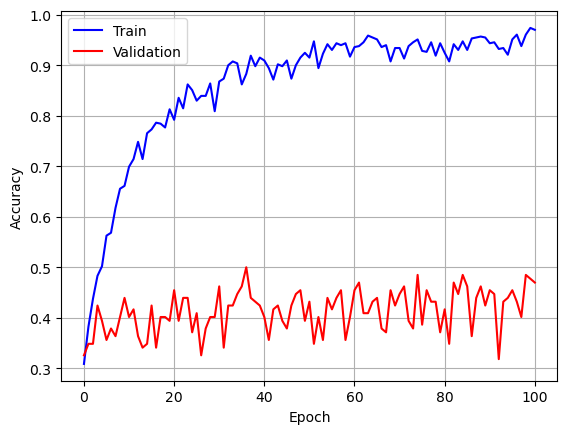

In [21]:
plt.plot(range(num_epochs), acc_train_hist, 'b-', label='Train')  # Train accuracy
plt.plot(range(num_epochs), acc_val_hist, 'r-', label='Validation')  # Validation accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


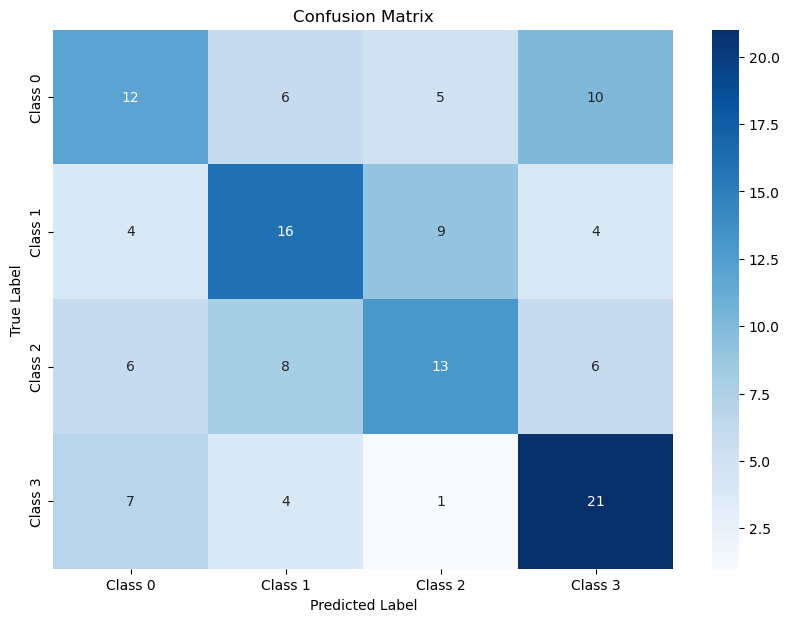

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# After training, we calculate predictions for the validation set
all_preds = []
all_targets = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for validation
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Get predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        all_preds.append(predicted.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Flatten the list of predictions and targets
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
